In [1]:
#Hello Cameron, This notebook calculates the EOF/PCA Analysis for the No Enso Run
#the framework of this code is provided from Harrison Tran @University of Wisconsin Madison: hktran3@wisc.edu

#import packages 
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
import xarray as xr
from netCDF4 import Dataset, num2date, date2num
from datetime import datetime

#For Map
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.ticker as mticker 
from matplotlib.patches import Rectangle
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

#Stuff for Meteorological calculations 
import metpy.calc as mpcalc
from metpy.plots import SkewT
from metpy.units import units

#Next thing: we need to know open up every file in the Dean Directory and loop through them!
import glob
import pandas as pd

#For stats
from scipy.stats import skew, norm

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
import cartopy.crs as ccrs

In [5]:
#First we open up the file path
filepath = '/Users/cameronmasiello/Desktop/Yearly_Sea_Surface_Larson/cesm*.nc'

#Find all netCDF files that match the pattern
datafiles = sorted(glob.glob(filepath))

#Open and combine the files along the 'time' dimension
combined_dataset = xr.open_mfdataset(datafiles, combine='by_coords')

#Review the combined dataset
print(combined_dataset)

<xarray.Dataset>
Dimensions:  (time: 2400, lat: 192, lon: 288)
Coordinates:
  * time     (time) object 1500-02-01 00:00:00 ... 1700-01-01 00:00:00
  * lat      (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Data variables:
    SST      (time, lat, lon) float32 dask.array<chunksize=(600, 192, 288), meta=np.ndarray>


In [6]:
###################################################################################################
#our data is monthly, so we will have to to take monthly averages! 

# This will calculate the mean SST for each calendar month over the entire time period
climatology = combined_dataset.groupby('time.month').mean('time')

# Step 2: Calculate Anomalies
# This subtracts the climatology from the original SST data to find the anomalies
anomalies = combined_dataset.groupby('time.month') - climatology

/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing with an out-of-order index is generating 50 times more chunks
  return self.array[key]


In [7]:
#now start EOF analysis

#Select the 'SST' DataArray from the Dataset
sst_anomalies = anomalies['SST']

#Perform polynomial fit (of degree 1 for linear trend) on the 'SST' DataArray
polyfit_results = sst_anomalies.polyfit(dim='time', deg=1)

#Extract the coefficients
coeffs = polyfit_results.polyfit_coefficients

#Evaluate the polynomial (the trend) at the given time coordinates
trend = xr.polyval(anomalies['time'], coeffs)

#Subtract the trend to detrend the data
detrended = sst_anomalies - trend

#Normalize by standard deviation
normalized_field = detrended / detrended.std('time')

#now we weight our field so higher latitudes are weighted based on their smaller spatial contribution
weighted_field = normalized_field * np.sqrt(np.cos(np.radians(normalized_field.lat)))

#finally, fill data points that are nan's with 0 values
weighted_field = weighted_field.fillna(0)

/opt/anaconda3/lib/python3.9/site-packages/xarray/core/computation.py:733: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


In [8]:
#This function was provided by Harrison:

def eof_spatial_analysis(field, n):
    """
    Given a spatial field [field] with dimensions (samples, x1, x2), compute the [n] leading eigenvectors, eigenvalues, 
    and principal components.
    """
    # Flatten array to form state sampled through the sampling dimension
    a, b, c = np.shape(field.values)  # Save dimensions of field
    state = field.values.reshape(a, b*c)

    # SVD decomposition of the state matrix
    U, S, V = LA.svd(state, full_matrices=False)

    eofs = V[:n, :].reshape(n, b, c)
    pcs = U[:, :n] * S[:n]
    evs = S[:n]**2

    # Normalize PCs
    pcs = (pcs - np.mean(pcs, axis=0)) / np.std(pcs, axis=0)

    return eofs, pcs, evs

# Now use the function to get the first 4 EOFs, PCs, and eigenvalues
eofs, pcs, evs = eof_spatial_analysis(weighted_field, 4)

/opt/anaconda3/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [9]:
#This calculates the EOF in terms of °C/Standard Deviation of SST Anomaly Data
eof_num = 1  # Index for the first EOF and PC

#Retrieve the original field data (this should be the data in units of °C before detrending and normalization)
#It's important that this data has the same spatial and temporal dimensions as the 'weighted_field' used in eof_spatial_analysis
state_orig = sst_anomalies.values  # 'original_field' should be the original SST data in °C
a, b, c = state_orig.shape

#Flatten the original state for projection
state_orig_flat = state_orig.reshape(a, b*c)

#Select the corresponding PC for the EOF pattern you want to visualize and standardize it
pc = pcs[:, eof_num - 1]
pc_std = (pc - np.mean(pc)) / np.std(pc)

#Project the standardized PC onto the EOF pattern
dn = (1.0 / np.size(state_orig_flat, axis=0)) * np.dot(pc_std, state_orig_flat)

#Reshape the result back to the original spatial dimensions
dnplot_1 = dn.reshape(b, c)

In [10]:
eofs_ds = xr.Dataset({
    'eof': xr.DataArray(eofs, 
                        coords={'mode': np.arange(1, 5), 
                                'lat': weighted_field.lat, 
                                'lon': weighted_field.lon}, 
                        dims=['mode', 'lat', 'lon']).assign_attrs({'name': 'EOF Spatial Pattern'}),
    
    'pc': xr.DataArray(pcs, 
                       coords={'time': detrended.time, 
                               'mode': np.arange(1, 5)}, 
                       dims=['time', 'mode']).assign_attrs({'name': 'Principal component timeseries'}),
    
    'pve': xr.DataArray(evs / np.sum(evs), 
                        coords={'mode': np.arange(1, 5)}, 
                        dims=['mode']).assign_attrs({'name': 'Percent variance explained'})
})


In [11]:
#dataproj = ccrs.PlateCarree(central_longitude=-160)
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker

def create_map_background(ax):
    # Set the extent of the map and add coastlines/features
    ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
    ax.coastlines('50m', linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=0.5)
    
    # Create a gridliner with labels on the left and bottom
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    gl.bottom_labels = True
    gl.left_labels = True
    gl.xlabel_style = {'size': 12, 'color': 'gray'}
    gl.ylabel_style = {'size': 12, 'color': 'gray'}
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
    gl.ylocator = mticker.FixedLocator(np.arange(-90, 91, 30))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

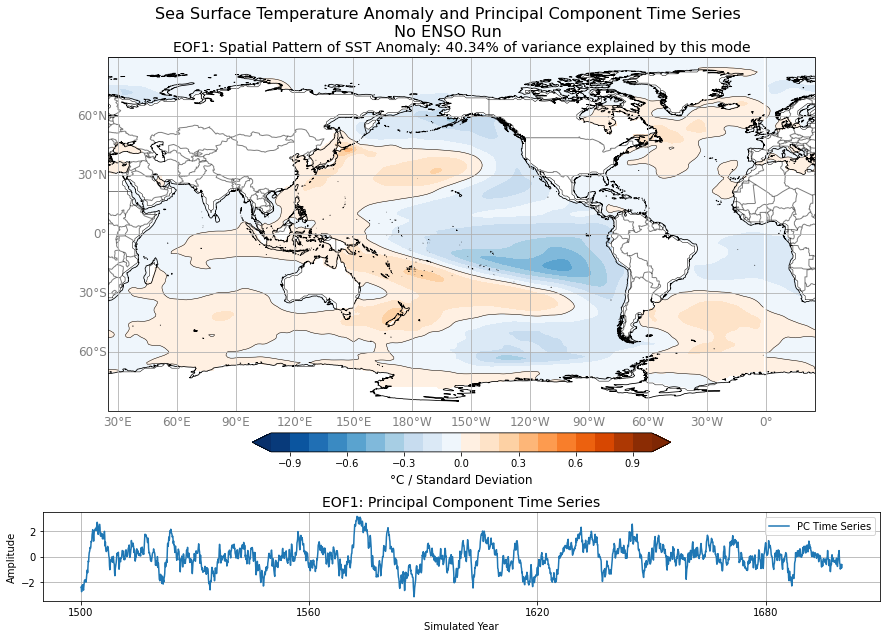

In [12]:
# Assuming 'eofs_ds' is your dataset with EOFs, and 'eof' is the key for your leading EOF pattern
lonsEOF = eofs_ds['lon']
latsEOF = eofs_ds['lat']
leading_eof = eofs_ds['eof'].sel(mode=1)  # Select the first EOF mode

# Create a figure with specified size and gridspec
fig = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(2, 1, height_ratios=[5, 1], hspace=0.05)

# Create the main map GeoAxes instance
ax = fig.add_subplot(gs[0, :], projection=ccrs.PlateCarree(central_longitude=-155))

# Use your existing function to set up the map background, passing in the GeoAxes instance
# You'll need to adjust the create_map_background() to accept an ax argument and work with it.
create_map_background(ax)

#Here we create a new color map to match Coral Reef Watch SST anomaly plots
bottom = cm.get_cmap('Oranges', 128)
top = cm.get_cmap('Blues_r', 128)

newcolors = np.vstack((top(np.linspace(0, 1, 50)),
                       bottom(np.linspace(0, 1, 50))))

newcmp = ListedColormap(newcolors, name='OrangeBlue')

# Plot the EOF data with contourf
cs = ax.contourf(lonsEOF, latsEOF, dnplot_1,
                 levels = np.arange(-1, 1.1, .1),  # Adjust levels appropriately
                 cmap=newcmp,
                 transform=ccrs.PlateCarree(),  # specify the data's projection
                 extend='both')

# Add a colorbar and labels
cbar = plt.colorbar(cs, orientation='horizontal', pad=0.05, shrink=0.5, aspect=20, ax=ax)
cbar.ax.set_xlabel('°C / Standard Deviation', fontsize=12)

# Add contour lines if needed
contour_lines = ax.contour(lonsEOF, latsEOF, leading_eof, 
                             levels=np.arange(-1, 1, 0.1),  # Choose appropriate contour levels
                             linestyles='-', linewidths=0.5, colors='k',
                             transform=ccrs.PlateCarree())

#ax.set_position([0.1, 0.3, 0.9, 0.6])  # Values are [left, bottom, width, height]

# Annotate the variance explained
pve = eofs_ds['pve'].sel(mode=1).item() * 100  # get the explained variance percentage
#ax.annotate(f'{pve:.2f}% of variance explained by this mode',
#            xy=(0.05, 0.1), xycoords='axes fraction', fontsize=12)

# Create the time series subplot
ax_ts = fig.add_subplot(gs[1, :])  # no projection here, it's a standard plot

# Plot the principal component time series
times = eofs_ds['time'].values  # adjust this line to get the time values correctly
pc_ts = eofs_ds['pc'].sel(mode=1)
ax_ts.plot(times, pc_ts, label='PC Time Series')
ax_ts.set_xlabel('Simulated Year')
ax_ts.set_ylabel('Amplitude')
ax_ts.legend(loc='upper right')
ax_ts.grid()

# Set a main title for the figure (adjust the y position as needed for your layout)
fig.suptitle('Sea Surface Temperature Anomaly and Principal Component Time Series\nNo ENSO Run', fontsize=16, y=0.95)

# Set titles for each subplot if needed
ax.set_title(f'EOF1: Spatial Pattern of SST Anomaly: {pve:.2f}% of variance explained by this mode', fontsize=14)
ax_ts.set_title('EOF1: Principal Component Time Series', fontsize=14)

#ax_ts.set_position([0.1, 0.05, 0.9, 0.2])  # Match the left and width with the ax above

plt.show()

In [13]:
# If pc_ts is an xarray DataArray, convert to numpy array first
pc_ts_values = pc_ts.values

# Now find the index of the maximum value
max_index = np.argmin(pc_ts_values)
print(max_index)

1050


In [14]:
#now, we gonna make a beautiful map of the North Atlantic

def create_map_background():
    dataproj = ccrs.PlateCarree(central_longitude=-160)
    fig= plt.figure(figsize=(64, 20))
    ax = plt.subplot(111, projection=dataproj)
    ax.set_extent([180, -180, -82, 82],ccrs.PlateCarree())
    ax.coastlines('50m', linewidth=1.5)
    ax.add_feature(cfeature.STATES, linewidth=1.0)
    ax.add_feature(cfeature.BORDERS, linewidth=1.0)
    gl = ax.gridlines(color='gray',alpha=0.5,draw_labels=True) 
    gl.xlabels_top, gl.ylabels_right = False, False
    gl.xlabel_style, gl.ylabel_style = {'fontsize': 16}, {'fontsize': 16}
    gl.xlocator = mticker.FixedLocator([380])
    gl.ylocator = mticker.FixedLocator([-90,-80,-60,-40,-20,0, 20, 40, 60, 80, 90])
    gl.xformatter = LongitudeFormatter(zero_direction_label=True)
    gl.yformatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(gl.xformatter)
    ax.yaxis.set_major_formatter(gl.yformatter)
    ax.stock_img()
    return fig, ax

/opt/anaconda3/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/var/folders/d_/plphgc7j2qdgppj6smtbjncc0000gn/T/ipykernel_1936/2536457466.py:21: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(css, orientation='horizontal', pad=0.05, shrink=0.3, aspect=30,
/opt/anaconda3/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: The following kwargs were not used by contour: 'l

Text(1.0, 1.0, 'Product By: Cameron Masiello')

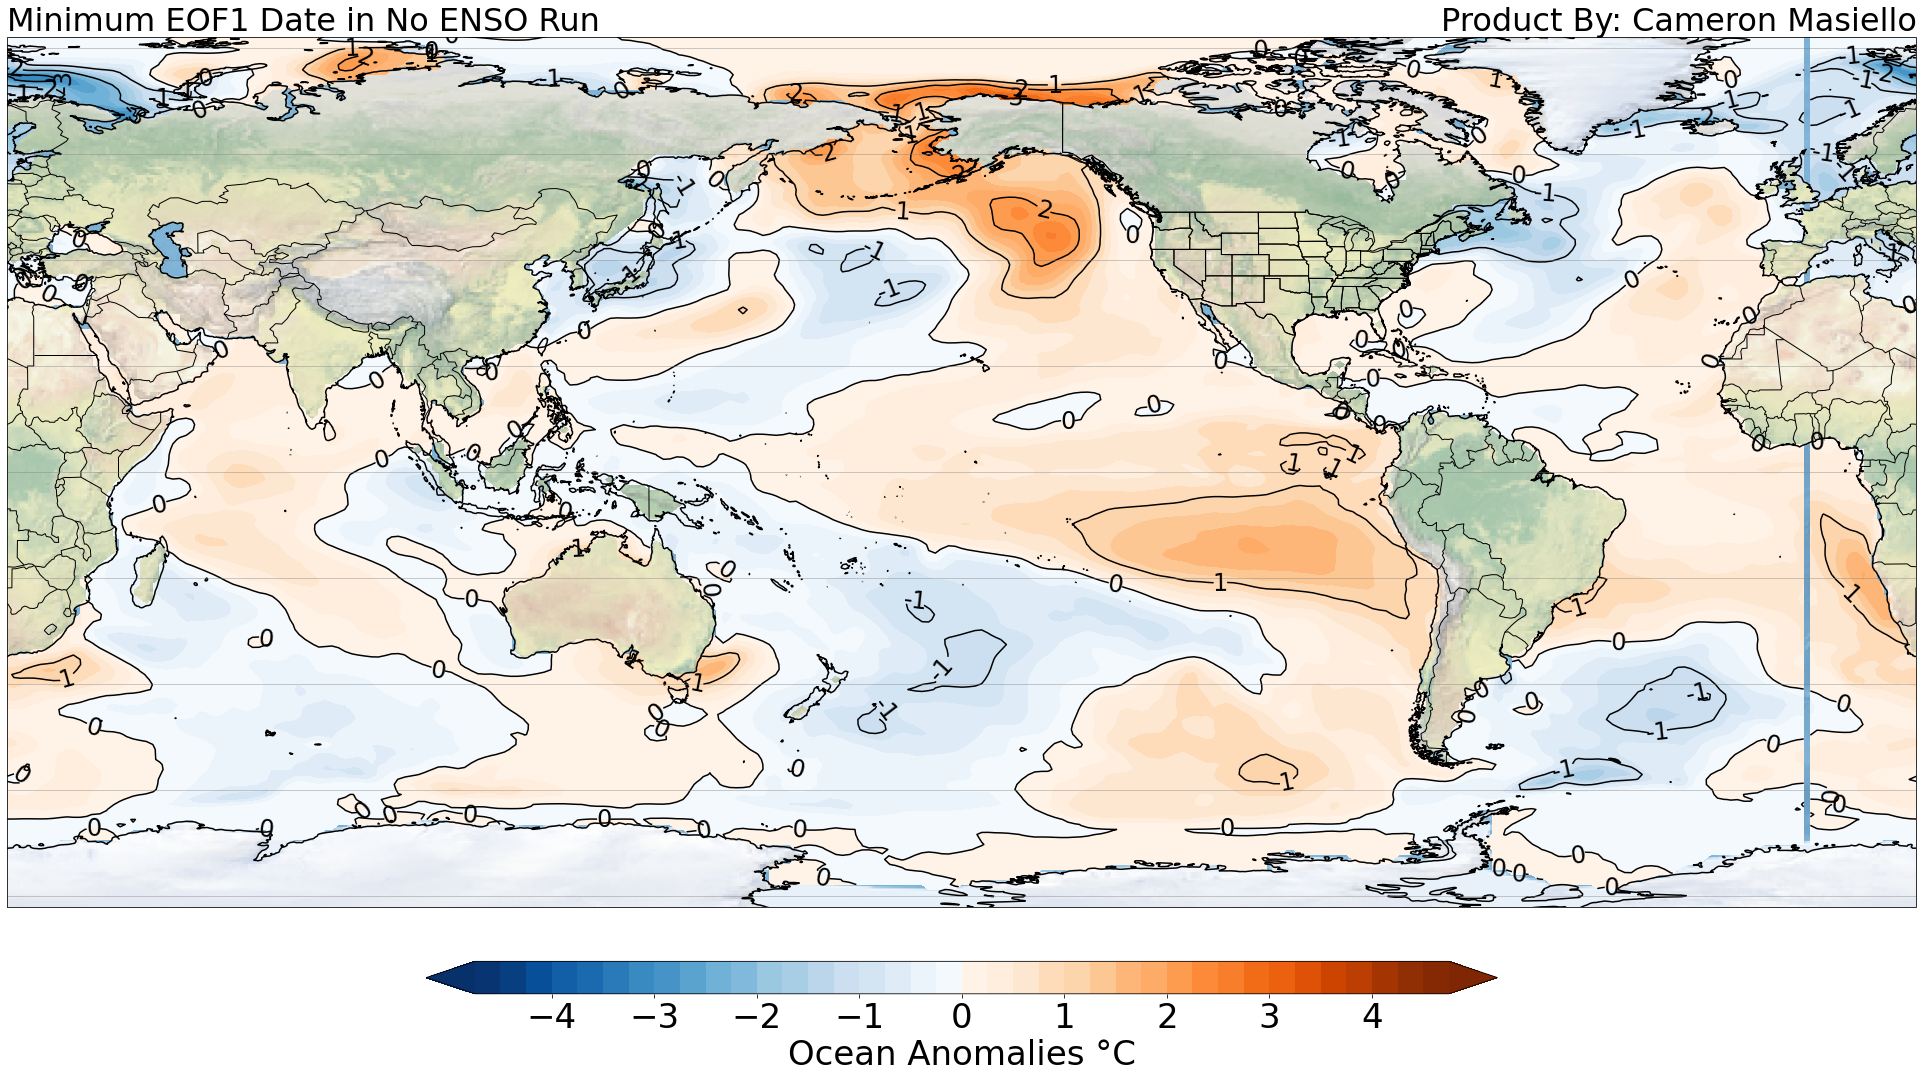

In [15]:
fig, ax = create_map_background()

sst_anomalies

#SST.plot()
lon = anomalies['lon']
lat = anomalies['lat']

#conlevels = np.linspace(0,30.0,101)

bottom = cm.get_cmap('Oranges', 128)
top = cm.get_cmap('Blues_r', 128)

newcolors = np.vstack((top(np.linspace(0, 1, 50)),
                       bottom(np.linspace(0, 1, 50))))

newcmp = ListedColormap(newcolors, name='OrangeBlue')

css = plt.contourf(lon, lat, anomalies['SST'][max_index,:,:], origin = 'lower', levels = np.arange(-4.75, 5.0, 0.25), cmap=newcmp, transform = ccrs.PlateCarree(),
                   extend='both')
cbar = plt.colorbar(css, orientation='horizontal', pad=0.05, shrink=0.3, aspect=30,
                    extend ='both')

#Set the colorbar tick label size
cbar.ax.tick_params(labelsize=34) 

cbar.ax.set_xlabel('Ocean Anomalies °C', fontsize = 34)

contourdifSSTglobeAnomaly = plt.contour(lon,lat,anomalies['SST'][max_index,:,:], np.arange(-4,5,1), linestyles = '-', linewidth = 0.1, colors = 'k',transform = ccrs.PlateCarree())
plt.clabel(contourdifSSTglobeAnomaly,fontsize = 24, inline = 1, fmt = '%1.0f')

plt.title('Minimum EOF1 Date in No ENSO Run ', loc='left',fontsize = 32)
plt.title(f'Product By: Cameron Masiello', loc='right',fontsize = 32)

/var/folders/d_/plphgc7j2qdgppj6smtbjncc0000gn/T/ipykernel_1936/1489904682.py:17: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(css, orientation='horizontal', pad=0.05, shrink=0.3, aspect=30,


Text(0.0, 1.0, 'EOF1 Global SST Anomalies No ENSO Run')

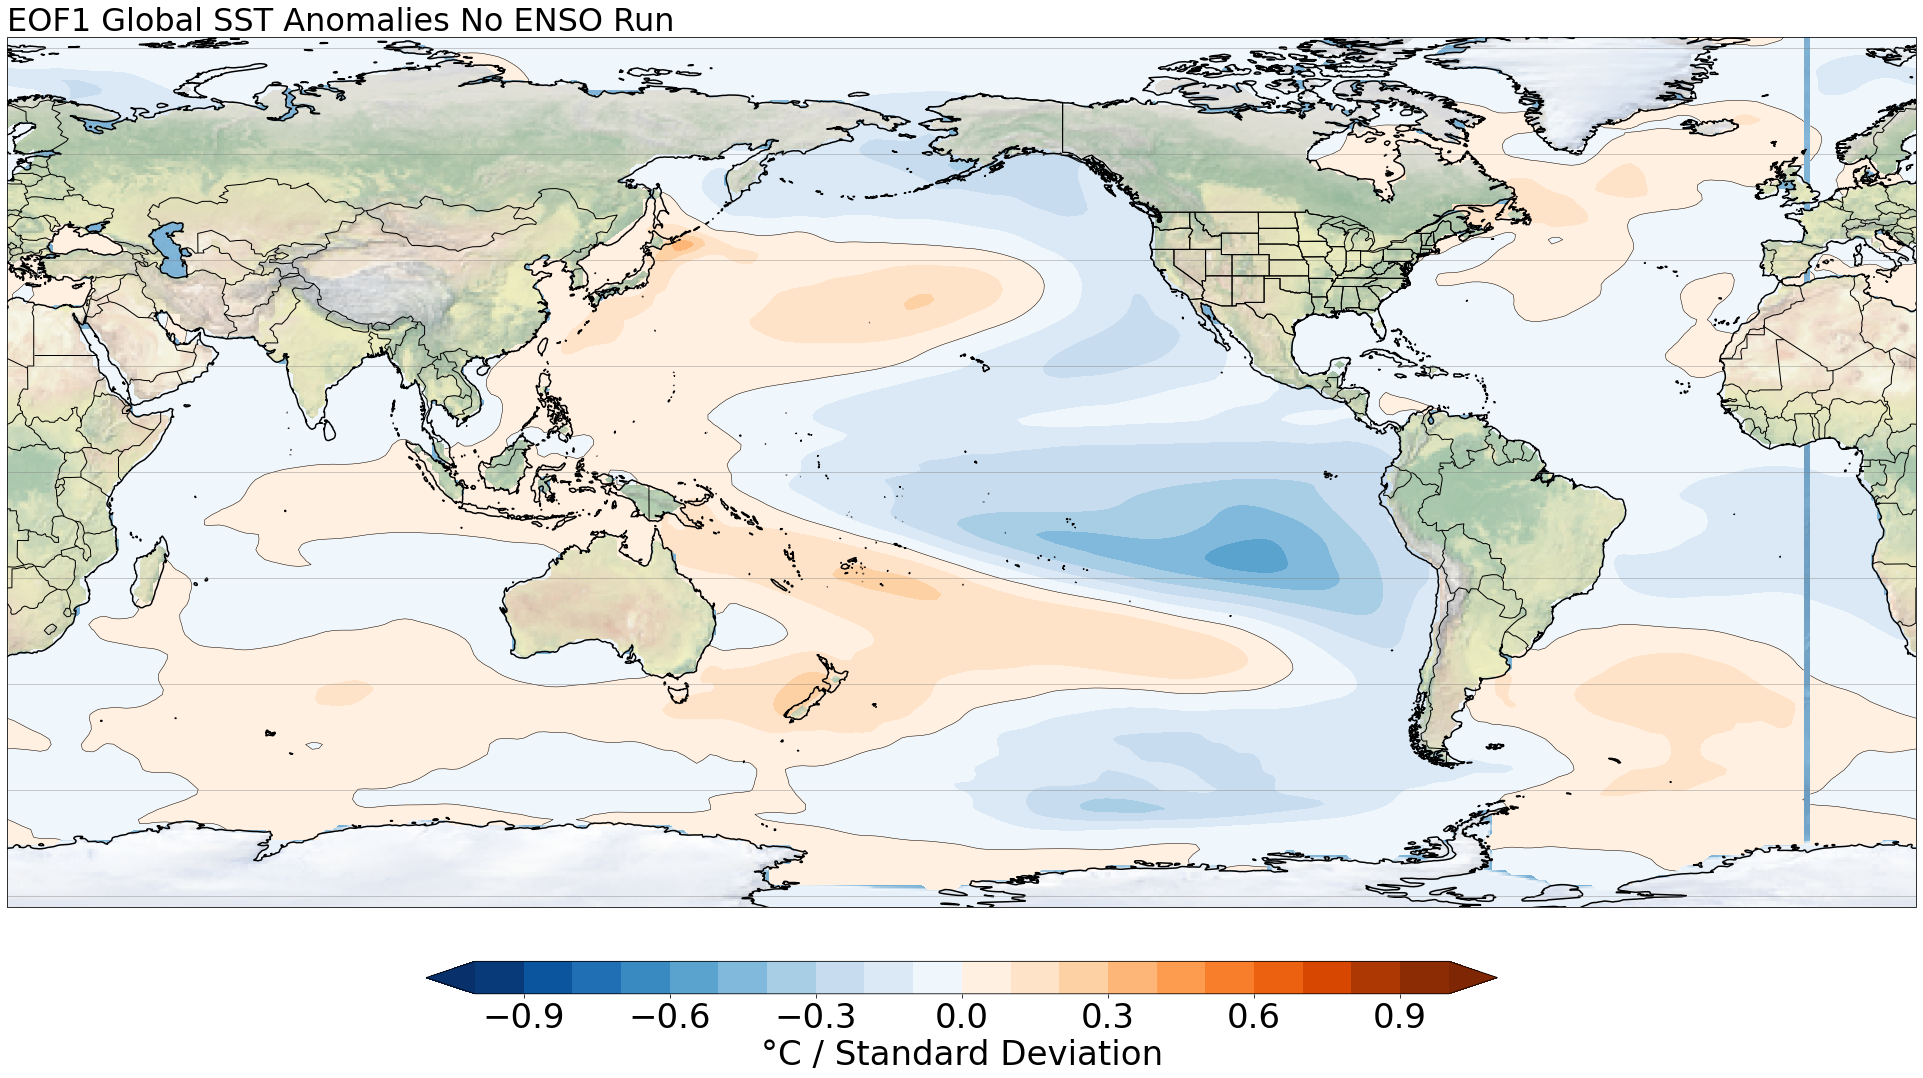

In [16]:
fig, ax = create_map_background()

bottom = cm.get_cmap('Oranges', 128)
top = cm.get_cmap('Blues_r', 128)

newcolors = np.vstack((top(np.linspace(0, 1, 50)),
                       bottom(np.linspace(0, 1, 50))))

newcmp = ListedColormap(newcolors, name='OrangeBlue')

css = plt.contourf(lonsEOF, latsEOF, dnplot_1,
                 levels = np.arange(-1, 1.1, .1),  # Adjust levels appropriately
                 cmap=newcmp,
                 transform=ccrs.PlateCarree(),  # specify the data's projection
                 extend='both')

cbar = plt.colorbar(css, orientation='horizontal', pad=0.05, shrink=0.3, aspect=30,
                    extend ='both')

#Set the colorbar tick label size
cbar.ax.tick_params(labelsize=34) 

cbar.ax.set_xlabel('°C / Standard Deviation', fontsize = 34)

contourdifSSTglobeAnomaly = plt.contour(lonsEOF, latsEOF, dnplot_1, 
                             levels=np.arange(-1, 1, 1),  # Choose appropriate contour levels
                             linestyles='-', linewidths=0.5, colors='k',
                             transform=ccrs.PlateCarree())

plt.title(f'EOF1 Global SST Anomalies No ENSO Run', loc='left',fontsize = 32)

In [ ]:
#This calculates the EOF in terms of °C/Standard Deviation of SST Anomaly Data
eof_num = 2  # Index for the first EOF and PC

#Retrieve the original field data (this should be the data in units of °C before detrending and normalization)
#It's important that this data has the same spatial and temporal dimensions as the 'weighted_field' used in eof_spatial_analysis
state_orig = sst_anomalies.values  # 'original_field' should be the original SST data in °C
a, b, c = state_orig.shape

#Flatten the original state for projection
state_orig_flat = state_orig.reshape(a, b*c)

#Select the corresponding PC for the EOF pattern you want to visualize and standardize it
pc = pcs[:, eof_num - 1]
pc_std = (pc - np.mean(pc)) / np.std(pc)

#Project the standardized PC onto the EOF pattern
dn = (1.0 / np.size(state_orig_flat, axis=0)) * np.dot(pc_std, state_orig_flat)

#Reshape the result back to the original spatial dimensions
dnplot_2 = dn.reshape(b, c)

In [ ]:
# Assuming 'eofs_ds' is your dataset with EOFs, and 'eof' is the key for your leading EOF pattern
lonsEOF = eofs_ds['lon']
latsEOF = eofs_ds['lat']
leading_eof = eofs_ds['eof'].sel(mode=2)  # Select the first EOF mode

# Create a figure with specified size and gridspec
fig = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(2, 1, height_ratios=[5, 1], hspace=0.05)

# Create the main map GeoAxes instance
ax = fig.add_subplot(gs[0, :], projection=ccrs.PlateCarree(central_longitude=-155))

# Use your existing function to set up the map background, passing in the GeoAxes instance
# You'll need to adjust the create_map_background() to accept an ax argument and work with it.
create_map_background(ax)

#Here we create a new color map to match Coral Reef Watch SST anomaly plots
bottom = cm.get_cmap('Oranges', 128)
top = cm.get_cmap('Blues_r', 128)

newcolors = np.vstack((top(np.linspace(0, 1, 50)),
                       bottom(np.linspace(0, 1, 50))))

newcmp = ListedColormap(newcolors, name='OrangeBlue')

# Plot the EOF data with contourf
cs = ax.contourf(lonsEOF, latsEOF, dnplot_2,
                 levels = np.arange(-1, 1.1, .1),  # Adjust levels appropriately
                 cmap=newcmp,
                 transform=ccrs.PlateCarree(),  # specify the data's projection
                 extend='both')

# Add a colorbar and labels
cbar = plt.colorbar(cs, orientation='horizontal', pad=0.05, shrink=0.5, aspect=20, ax=ax)
cbar.ax.set_xlabel('°C / Standard Deviation', fontsize=12)

# Add contour lines if needed
contour_lines = ax.contour(lonsEOF, latsEOF, dnplot_2, 
                             levels=np.arange(-1, 1, 1),  # Choose appropriate contour levels
                             linestyles='-', linewidths=0.5, colors='k',
                             transform=ccrs.PlateCarree())

#ax.set_position([0.1, 0.3, 0.9, 0.6])  # Values are [left, bottom, width, height]

# Annotate the variance explained
pve = eofs_ds['pve'].sel(mode=2).item() * 100  # get the explained variance percentage
#ax.annotate(f'{pve:.2f}% of variance explained by this mode',
#            xy=(0.05, 0.1), xycoords='axes fraction', fontsize=12)

# Create the time series subplot
ax_ts = fig.add_subplot(gs[1, :])  # no projection here, it's a standard plot

# Plot the principal component time series
times = eofs_ds['time'].values  # adjust this line to get the time values correctly
pc_ts_2 = eofs_ds['pc'].sel(mode=2)
ax_ts.plot(times, pc_ts_2, label='PC Time Series')
ax_ts.set_xlabel('Simulated Year')
ax_ts.set_ylabel('Amplitude')
ax_ts.legend(loc='upper right')
ax_ts.grid()

# Set a main title for the figure (adjust the y position as needed for your layout)
fig.suptitle('Sea Surface Temperature Anomaly and Principal Component Time Series\nNo ENSO Run', fontsize=16, y=0.95)

# Set titles for each subplot if needed
ax.set_title(f'EOF2: Spatial Pattern of SST Anomaly: {pve:.2f}% of variance explained by this mode', fontsize=14)
ax_ts.set_title('EOF2: Principal Component Time Series', fontsize=14, pad=3)


plt.show()

In [ ]:
# If pc_ts is an xarray DataArray, convert to numpy array first
pc_ts_values = pc_ts_2.values

# Now find the index of the maximum value
max_index = np.argmax(pc_ts_values)
print(max_index)

In [ ]:
fig, ax = create_map_background()

sst_anomalies

#SST.plot()
lon = anomalies['lon']
lat = anomalies['lat']

#conlevels = np.linspace(0,30.0,101)

bottom = cm.get_cmap('Oranges', 128)
top = cm.get_cmap('Blues_r', 128)

newcolors = np.vstack((top(np.linspace(0, 1, 50)),
                       bottom(np.linspace(0, 1, 50))))

newcmp = ListedColormap(newcolors, name='OrangeBlue')

css = plt.contourf(lon, lat, anomalies['SST'][max_index,:,:], origin = 'lower', levels = np.arange(-4.75, 5.0, 0.25), cmap=newcmp, transform = ccrs.PlateCarree(),
                   extend='both')
cbar = plt.colorbar(css, orientation='horizontal', pad=0.05, shrink=0.3, aspect=30,
                    extend ='both')

#Set the colorbar tick label size
cbar.ax.tick_params(labelsize=34) 

cbar.ax.set_xlabel('Ocean Anomalies °C', fontsize = 34)

contourdifSSTglobeAnomaly = plt.contour(lon,lat,anomalies['SST'][max_index,:,:], np.arange(-4,5,1), linestyles = '-', linewidth = 0.1, colors = 'k',transform = ccrs.PlateCarree())
plt.clabel(contourdifSSTglobeAnomaly,fontsize = 24, inline = 1, fmt = '%1.0f')

plt.title('Maximum EOF2 Date in No ENSO Run ', loc='left',fontsize = 32)
plt.title(f'Product By: Cameron Masiello', loc='right',fontsize = 32)

In [ ]:
#This calculates the EOF in terms of °C/Standard Deviation of SST Anomaly Data
eof_num = 3  # Index for the first EOF and PC

#Retrieve the original field data (this should be the data in units of °C before detrending and normalization)
#It's important that this data has the same spatial and temporal dimensions as the 'weighted_field' used in eof_spatial_analysis
state_orig = sst_anomalies.values  # 'original_field' should be the original SST data in °C
a, b, c = state_orig.shape

#Flatten the original state for projection
state_orig_flat = state_orig.reshape(a, b*c)

#Select the corresponding PC for the EOF pattern you want to visualize and standardize it
pc = pcs[:, eof_num - 1]
pc_std = (pc - np.mean(pc)) / np.std(pc)

#Project the standardized PC onto the EOF pattern
dn = (1.0 / np.size(state_orig_flat, axis=0)) * np.dot(pc_std, state_orig_flat)

#Reshape the result back to the original spatial dimensions
dnplot_3 = dn.reshape(b, c)

In [ ]:
# Assuming 'eofs_ds' is your dataset with EOFs, and 'eof' is the key for your leading EOF pattern
lonsEOF = eofs_ds['lon']
latsEOF = eofs_ds['lat']
leading_eof = eofs_ds['eof'].sel(mode=3)  # Select the first EOF mode

# Create a figure with specified size and gridspec
fig = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(2, 1, height_ratios=[5, 1], hspace=0.05)

# Create the main map GeoAxes instance
ax = fig.add_subplot(gs[0, :], projection=ccrs.PlateCarree(central_longitude=-155))

# Use your existing function to set up the map background, passing in the GeoAxes instance
# You'll need to adjust the create_map_background() to accept an ax argument and work with it.
create_map_background(ax)

#Here we create a new color map to match Coral Reef Watch SST anomaly plots
bottom = cm.get_cmap('Oranges', 128)
top = cm.get_cmap('Blues_r', 128)

newcolors = np.vstack((top(np.linspace(0, 1, 50)),
                       bottom(np.linspace(0, 1, 50))))

newcmp = ListedColormap(newcolors, name='OrangeBlue')

# Plot the EOF data with contourf
cs = ax.contourf(lonsEOF, latsEOF, dnplot_3,
                 levels = np.arange(-1, 1.1, .1),  # Adjust levels appropriately
                 cmap=newcmp,
                 transform=ccrs.PlateCarree(),  # specify the data's projection
                 extend='both')

# Add a colorbar and labels
cbar = plt.colorbar(cs, orientation='horizontal', pad=0.05, shrink=0.5, aspect=20, ax=ax)
cbar.ax.set_xlabel('°C / Standard Deviation', fontsize=12)

# Add contour lines if needed
contour_lines = ax.contour(lonsEOF, latsEOF, dnplot_3, 
                             levels=np.arange(-1, 1, 1),  # Choose appropriate contour levels
                             linestyles='-', linewidths=0.5, colors='k',
                             transform=ccrs.PlateCarree())

#ax.set_position([0.1, 0.3, 0.9, 0.6])  # Values are [left, bottom, width, height]

# Annotate the variance explained
pve = eofs_ds['pve'].sel(mode=3).item() * 100  # get the explained variance percentage
#ax.annotate(f'{pve:.2f}% of variance explained by this mode',
#            xy=(0.05, 0.1), xycoords='axes fraction', fontsize=12)

# Create the time series subplot
ax_ts = fig.add_subplot(gs[1, :])  # no projection here, it's a standard plot

# Plot the principal component time series
times = eofs_ds['time'].values  # adjust this line to get the time values correctly
pc_ts_3 = eofs_ds['pc'].sel(mode=3)
ax_ts.plot(times, pc_ts_3, label='PC Time Series')
ax_ts.set_xlabel('Simulated Year')
ax_ts.set_ylabel('Amplitude')
ax_ts.legend(loc='upper right')
ax_ts.grid()

# Set a main title for the figure (adjust the y position as needed for your layout)
fig.suptitle('Sea Surface Temperature Anomaly and Principal Component Time Series\nNo ENSO Run', fontsize=16, y=0.95)

# Set titles for each subplot if needed
ax.set_title(f'EOF3: Spatial Pattern of SST Anomaly: {pve:.2f}% of variance explained by this mode', fontsize=14)
ax_ts.set_title('EOF3: Principal Component Time Series', fontsize=14, pad=3)


plt.show()

In [ ]:
# If pc_ts is an xarray DataArray, convert to numpy array first
pc_ts_values = pc_ts_3.values

# Now find the index of the maximum value
max_index_3 = np.argmax(pc_ts_values)
print(max_index_3)

In [ ]:
fig, ax = create_map_background()

sst_anomalies

#SST.plot()
lon = anomalies['lon']
lat = anomalies['lat']

#conlevels = np.linspace(0,30.0,101)

bottom = cm.get_cmap('Oranges', 128)
top = cm.get_cmap('Blues_r', 128)

newcolors = np.vstack((top(np.linspace(0, 1, 50)),
                       bottom(np.linspace(0, 1, 50))))

newcmp = ListedColormap(newcolors, name='OrangeBlue')

css = plt.contourf(lon, lat, anomalies['SST'][max_index_3,:,:], origin = 'lower', levels = np.arange(-4.75, 5.0, 0.25), cmap=newcmp, transform = ccrs.PlateCarree(),
                   extend='both')
cbar = plt.colorbar(css, orientation='horizontal', pad=0.05, shrink=0.3, aspect=30,
                    extend ='both')

#Set the colorbar tick label size
cbar.ax.tick_params(labelsize=34) 

cbar.ax.set_xlabel('Ocean Anomalies °C', fontsize = 34)

contourdifSSTglobeAnomaly = plt.contour(lon,lat,anomalies['SST'][max_index_3,:,:], np.arange(-4,5,1), linestyles = '-', linewidth = 0.1, colors = 'k',transform = ccrs.PlateCarree())
plt.clabel(contourdifSSTglobeAnomaly,fontsize = 24, inline = 1, fmt = '%1.0f')

plt.title('Maximum EOF3 Date in No ENSO Run ', loc='left',fontsize = 32)
plt.title(f'Product By: Cameron Masiello', loc='right',fontsize = 32)

In [ ]:
#This calculates the EOF in terms of °C/Standard Deviation of SST Anomaly Data
eof_num = 4  # Index for the first EOF and PC

#Retrieve the original field data (this should be the data in units of °C before detrending and normalization)
#It's important that this data has the same spatial and temporal dimensions as the 'weighted_field' used in eof_spatial_analysis
state_orig = sst_anomalies.values  # 'original_field' should be the original SST data in °C
a, b, c = state_orig.shape

#Flatten the original state for projection
state_orig_flat = state_orig.reshape(a, b*c)

#Select the corresponding PC for the EOF pattern you want to visualize and standardize it
pc = pcs[:, eof_num - 1]
pc_std = (pc - np.mean(pc)) / np.std(pc)

#Project the standardized PC onto the EOF pattern
dn = (1.0 / np.size(state_orig_flat, axis=0)) * np.dot(pc_std, state_orig_flat)

#Reshape the result back to the original spatial dimensions
dnplot_4 = dn.reshape(b, c)

In [ ]:
# Assuming 'eofs_ds' is your dataset with EOFs, and 'eof' is the key for your leading EOF pattern
lonsEOF = eofs_ds['lon']
latsEOF = eofs_ds['lat']
leading_eof = eofs_ds['eof'].sel(mode=4)  # Select the first EOF mode

# Create a figure with specified size and gridspec
fig = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(2, 1, height_ratios=[5, 1], hspace=0.05)

# Create the main map GeoAxes instance
ax = fig.add_subplot(gs[0, :], projection=ccrs.PlateCarree(central_longitude=-155))

# Use your existing function to set up the map background, passing in the GeoAxes instance
# You'll need to adjust the create_map_background() to accept an ax argument and work with it.
create_map_background(ax)

#Here we create a new color map to match Coral Reef Watch SST anomaly plots
bottom = cm.get_cmap('Oranges', 128)
top = cm.get_cmap('Blues_r', 128)

newcolors = np.vstack((top(np.linspace(0, 1, 50)),
                       bottom(np.linspace(0, 1, 50))))

newcmp = ListedColormap(newcolors, name='OrangeBlue')

# Plot the EOF data with contourf
cs = ax.contourf(lonsEOF, latsEOF, dnplot_4,
                 levels = np.arange(-1, 1.1, .1),  # Adjust levels appropriately
                 cmap=newcmp,
                 transform=ccrs.PlateCarree(),  # specify the data's projection
                 extend='both')

# Add a colorbar and labels
cbar = plt.colorbar(cs, orientation='horizontal', pad=0.05, shrink=0.5, aspect=20, ax=ax)
cbar.ax.set_xlabel('°C / Standard Deviation', fontsize=12)

# Add contour lines if needed
contour_lines = ax.contour(lonsEOF, latsEOF, dnplot_4, 
                             levels=np.arange(-1, 1, 1),  # Choose appropriate contour levels
                             linestyles='-', linewidths=0.5, colors='k',
                             transform=ccrs.PlateCarree())

#ax.set_position([0.1, 0.3, 0.9, 0.6])  # Values are [left, bottom, width, height]

# Annotate the variance explained
pve = eofs_ds['pve'].sel(mode=4).item() * 100  # get the explained variance percentage
#ax.annotate(f'{pve:.2f}% of variance explained by this mode',
#            xy=(0.05, 0.1), xycoords='axes fraction', fontsize=12)

# Create the time series subplot
ax_ts = fig.add_subplot(gs[1, :])  # no projection here, it's a standard plot

# Plot the principal component time series
times = eofs_ds['time'].values  # adjust this line to get the time values correctly
pc_ts_4 = eofs_ds['pc'].sel(mode=4)
ax_ts.plot(times, pc_ts_4, label='PC Time Series')
ax_ts.set_xlabel('Simulated Year')
ax_ts.set_ylabel('Amplitude')
ax_ts.legend(loc='upper right')
ax_ts.grid()

# Set a main title for the figure (adjust the y position as needed for your layout)
fig.suptitle('Sea Surface Temperature Anomaly and Principal Component Time Series\nNo ENSO Run', fontsize=16, y=0.95)

# Set titles for each subplot if needed
ax.set_title(f'EOF4: Spatial Pattern of SST Anomaly: {pve:.2f}% of variance explained by this mode', fontsize=14)
ax_ts.set_title('EOF4: Principal Component Time Series', fontsize=14, pad=3)

plt.show()

In [ ]:
# If pc_ts is an xarray DataArray, convert to numpy array first
pc_ts_values = pc_ts_4.values

# Now find the index of the maximum value
max_index_4 = np.argmax(pc_ts_values)
print(max_index_4)

In [ ]:
fig, ax = create_map_background()

sst_anomalies

#SST.plot()
lon = anomalies['lon']
lat = anomalies['lat']

#conlevels = np.linspace(0,30.0,101)

bottom = cm.get_cmap('Oranges', 128)
top = cm.get_cmap('Blues_r', 128)

newcolors = np.vstack((top(np.linspace(0, 1, 50)),
                       bottom(np.linspace(0, 1, 50))))

newcmp = ListedColormap(newcolors, name='OrangeBlue')

css = plt.contourf(lon, lat, anomalies['SST'][max_index_4,:,:], origin = 'lower', levels = np.arange(-4.75, 5.0, 0.25), cmap=newcmp, transform = ccrs.PlateCarree(),
                   extend='both')
cbar = plt.colorbar(css, orientation='horizontal', pad=0.05, shrink=0.3, aspect=30,
                    extend ='both')

#Set the colorbar tick label size
cbar.ax.tick_params(labelsize=34) 

cbar.ax.set_xlabel('Ocean Anomalies °C', fontsize = 34)

contourdifSSTglobeAnomaly = plt.contour(lon,lat,anomalies['SST'][max_index_4,:,:], np.arange(-4,5,1), linestyles = '-', linewidth = 0.1, colors = 'k',transform = ccrs.PlateCarree())
plt.clabel(contourdifSSTglobeAnomaly,fontsize = 24, inline = 1, fmt = '%1.0f')

plt.title('Maximum EOF4 Date in No ENSO Run ', loc='left',fontsize = 12)
plt.title(f'Product By: Cameron Masiello', loc='right',fontsize = 12)